In [109]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error


In [110]:
df = pd.read_csv("../data/household_power_consumption.txt", sep=";")

C:\Users\mohit\AppData\Local\Temp\ipykernel_2132\2012164185.py:1: DtypeWarning: Columns (0: Global_active_power, 1: Global_reactive_power, 2: Voltage, 3: Global_intensity, 4: Sub_metering_1, 5: Sub_metering_2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/household_power_consumption.txt", sep=";")


In [111]:
df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [112]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   str    
 1   Time                   str    
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(6), str(2)
memory usage: 142.5+ MB


In [113]:
df.isna().sum()


Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [114]:
df.replace("?", np.nan, inplace=True)
df = df.dropna()


In [115]:
for col in df.columns:
    if col not in ["Date", "Time"]:
        df[col] = df[col].astype(float)


In [116]:
df["Datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S"
)


In [117]:
df = df.sort_values("Datetime")
df = df.set_index("Datetime")


In [118]:
df = df.drop(columns=["Date", "Time"])


In [119]:
df.index.is_monotonic_increasing


True

In [120]:
HORIZON = 1
df['target'] = df['Global_active_power'].shift(-HORIZON)

df = df.dropna()

In [121]:
# Create lag features BEFORE dropping Global_active_power
HORIZON = 1

for lag in [1, 2, 5, 10, 30, 60]:
    df[f'lag_{lag}'] = df['Global_active_power'].shift(lag)

# Create rolling features
df['rolling_mean_30'] = df['Global_active_power'].shift(HORIZON).rolling(10).mean()
df['rolling_std_30']  = df['Global_active_power'].shift(HORIZON).rolling(10).std()

# NOW drop the leaky features
leaky_features = [
    "Global_active_power",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

df = df.drop(columns=leaky_features)

# Drop rows with NaN values created by lag/rolling operations
df = df.dropna()


In [122]:
feature_cols = [c for c in df.columns if c.startswith('lag_') or c.startswith('rolling_')]

X = df[feature_cols]
y = df['target']


In [123]:
train_size = int(len(df) * 0.8)

train = df.iloc[:train_size]
test  = df.iloc[train_size:]

X_train = train.drop(columns=["target"])
y_train = train["target"]

X_test  = test.drop(columns=["target"])
y_test  = test["target"]

In [124]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [125]:
#Baseline model

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


In [126]:
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R2 Score: 0.8791517345033797
MAE: 0.14256248834287555


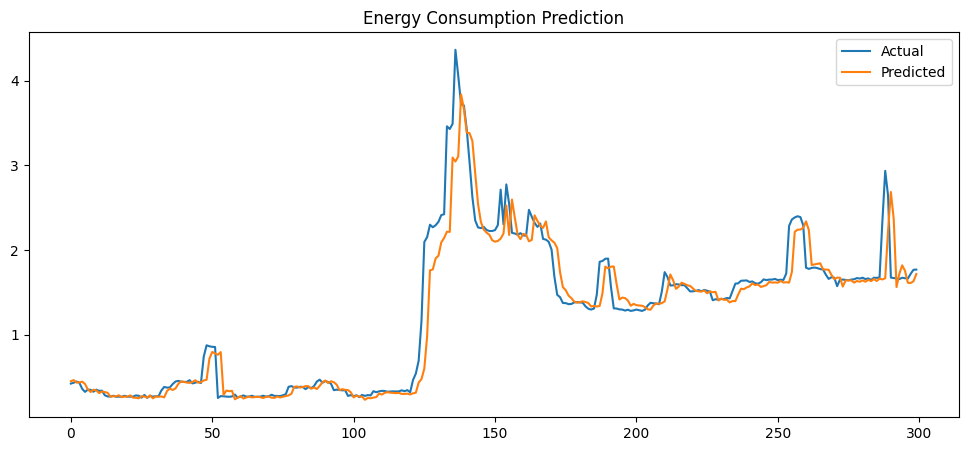

In [127]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:300], label="Actual")
plt.plot(y_pred[:300], label="Predicted")
plt.legend()
plt.title("Energy Consumption Prediction")
plt.show()


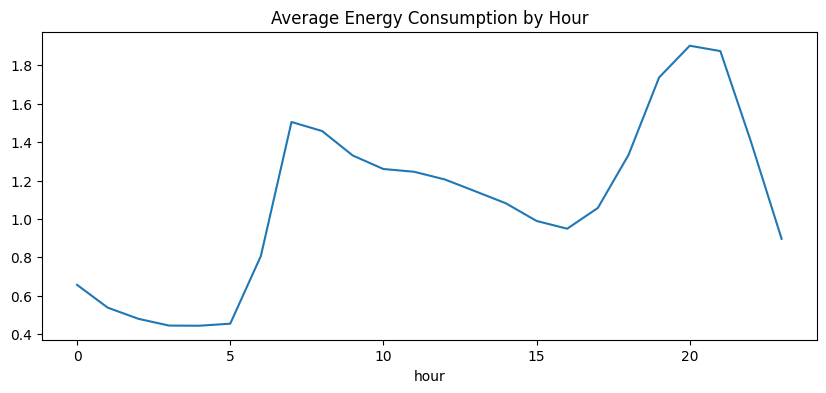

In [128]:
df["hour"] = df.index.hour

df.groupby("hour")["target"].mean().plot(
    title="Average Energy Consumption by Hour",
    figsize=(10,4)
)
plt.show()


In [129]:
train_pred = model.predict(X_train_scaled)

print("Train R2:", r2_score(y_train, train_pred))
print("Test R2:", r2_score(y_test, y_pred))


Train R2: 0.8764690767983232
Test R2: 0.8791517345033797


In [130]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

print("XGB R2:", r2_score(y_test, xgb_pred))
print("XGB MAE:", mean_absolute_error(y_test, xgb_pred))


XGB R2: 0.8900358456670154
XGB MAE: 0.12710706689454876
